In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import yfinance as yf
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

In [ ]:
# Extraction des données sur le SP500 en 1h
data = yf.download('^GSPC', period='730d', interval='1h', prepost=True)
data = data.droplevel(level=1, axis=1)

# Certains volumes peuvent être à 0 sur Yahoo Finance (souvent en fin de séance quand les volumes sont faibles).
# Dans ce cas, je les remplace par le volume de l'heure précédente.
data['Volume'] = data['Volume'].mask(data['Volume'] == 0).ffill()

# Return, c'est la variation en pourcentage entre l'heure précédente et l'heure actuelle.
data['Return'] = data['Close'].pct_change()

data.head()

Téléchargement des données...


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Return
Datetime,,,,,,
2022-05-09 13:30:00+00:00,4034.159912,4081.270020,4032.699951,4081.270020,NaN,NaN
2022-05-09 14:30:00+00:00,4010.709961,4039.280029,4009.340088,4034.209961,417559003.0,-0.005813
2022-05-09 15:30:00+00:00,4041.080078,4050.209961,4003.169922,4010.679932,334837856.0,0.007572
2022-05-09 16:30:00+00:00,4024.959961,4047.389893,4010.689941,4041.290039,258554000.0,-0.003989
2022-05-09 17:30:00+00:00,4010.040039,4028.159912,4004.350098,4024.979980,287488000.0,-0.003707


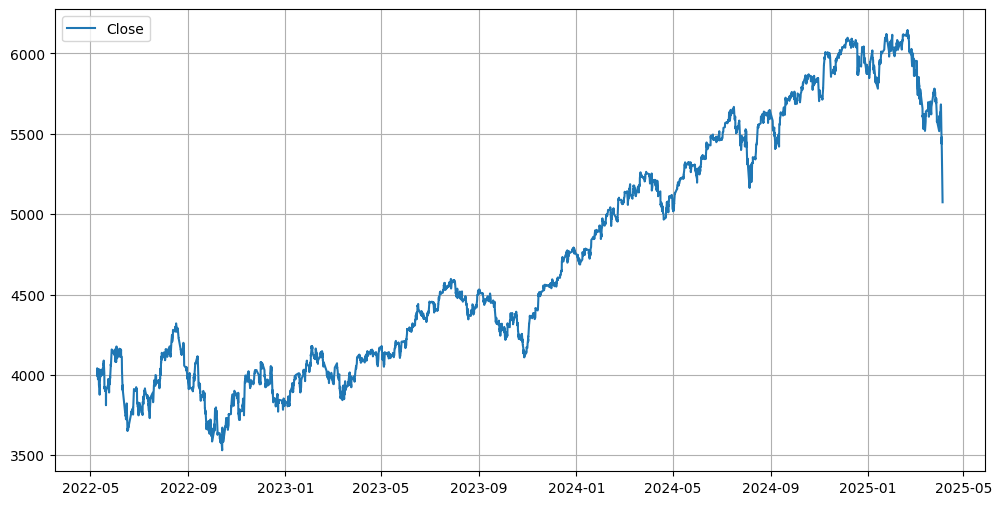

In [134]:
plt.figure(figsize=(12,6))
plt.plot(data["Close"], label='Close')
plt.legend()
plt.grid()
plt.show()

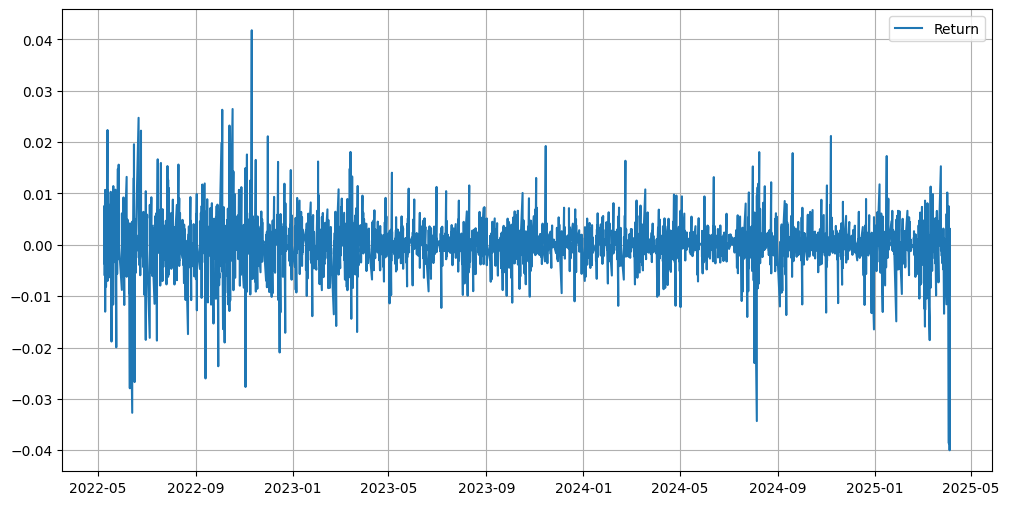

In [135]:
plt.figure(figsize=(12,6))
plt.plot(data["Return"], label='Return')
plt.legend()
plt.grid()
plt.show()

### Il est important de se poser la question suivante : pour prédire l'évolution du cours dans les prochains jours, est-il plus cohérent de prévoir la variation du prix ou le prix lui-même ?

### Faut-il prédire le prix exact ou plutôt anticiper une variation de X % du prix ?

### À mon avis, la prédiction de la variation est plus scalable et efficace sur différents indices et actions en bourse que la prédiction du prix absolu. Cependant, la valeur absolue reste plus simple à visualiser et à interpréter, ce qui facilite la prise de décision sur un dashboard.

### Puisque notre projet a pour objectif de fournir une aide à la décision, nous choisissons de prédire le prix de clôture (Close). Toutefois, si notre but était de déployer un modèle en production pour investir de manière autonome, la prédiction des rendements (returns) serait un excellent choix.

In [ ]:
data.shape
# Il n'y a pas beaucoup de données, risque d'overfitting et d'underfitting,
# il faudra être précautionneux pour la construction du modèle.

(6319, 6)

In [ ]:
# Valeurs manquantes
print(data.isnull().sum())

Price
Close     0
High      0
Low       0
Open      0
Volume    1
Return    1
dtype: int64


In [97]:
data = data.dropna()
data.head()

Price,Close,High,Low,Open,Volume,Return
Datetime,,,,,,
2022-05-09 14:30:00+00:00,4010.709961,4039.280029,4009.340088,4034.209961,417559003.0,-0.005813
2022-05-09 15:30:00+00:00,4041.080078,4050.209961,4003.169922,4010.679932,334837856.0,0.007572
2022-05-09 16:30:00+00:00,4024.959961,4047.389893,4010.689941,4041.290039,258554000.0,-0.003989
2022-05-09 17:30:00+00:00,4010.040039,4028.159912,4004.350098,4024.979980,287488000.0,-0.003707
2022-05-09 18:30:00+00:00,4005.729980,4034.300049,4001.050049,4010.090088,363135000.0,-0.001075


In [98]:
# On examine les outliers, mais sur les marchés financiers, ils sont souvent très significatifs.
# On évite donc de les supprimer.
fig = make_subplots(rows=1, cols=len(data.columns), subplot_titles=data.columns)

for i, col in enumerate(data.columns):
    fig.add_trace(go.Box(y=data[col], name=col), row=1, col=i+1)

fig.update_layout(title_text="Outlier", showlegend=False)
fig.show()

In [99]:
data.describe()

Price,Close,High,Low,Open,Volume,Return
count,6318.000000,6318.000000,6318.000000,6318.000000,6.318000e+03,6318.000000
mean,4714.061574,4721.418083,4706.261152,4713.996278,2.844496e+08,0.000043
std,747.156939,747.172820,747.078776,747.283152,2.932830e+08,0.003569
min,3530.909912,3550.969971,3491.580078,3520.370117,1.730000e+05,-0.040002
25%,4064.802490,4072.432500,4057.074951,4063.412476,1.918547e+08,-0.000961
50%,4488.005127,4492.020020,4482.525146,4488.349854,2.472825e+08,0.000000
75%,5421.120117,5429.047607,5409.955078,5422.017578,3.316615e+08,0.001207
max,6144.150000,6147.430176,6144.090000,6144.440000,4.192067e+09,0.041760


<Axes: xlabel='Price', ylabel='Price'>

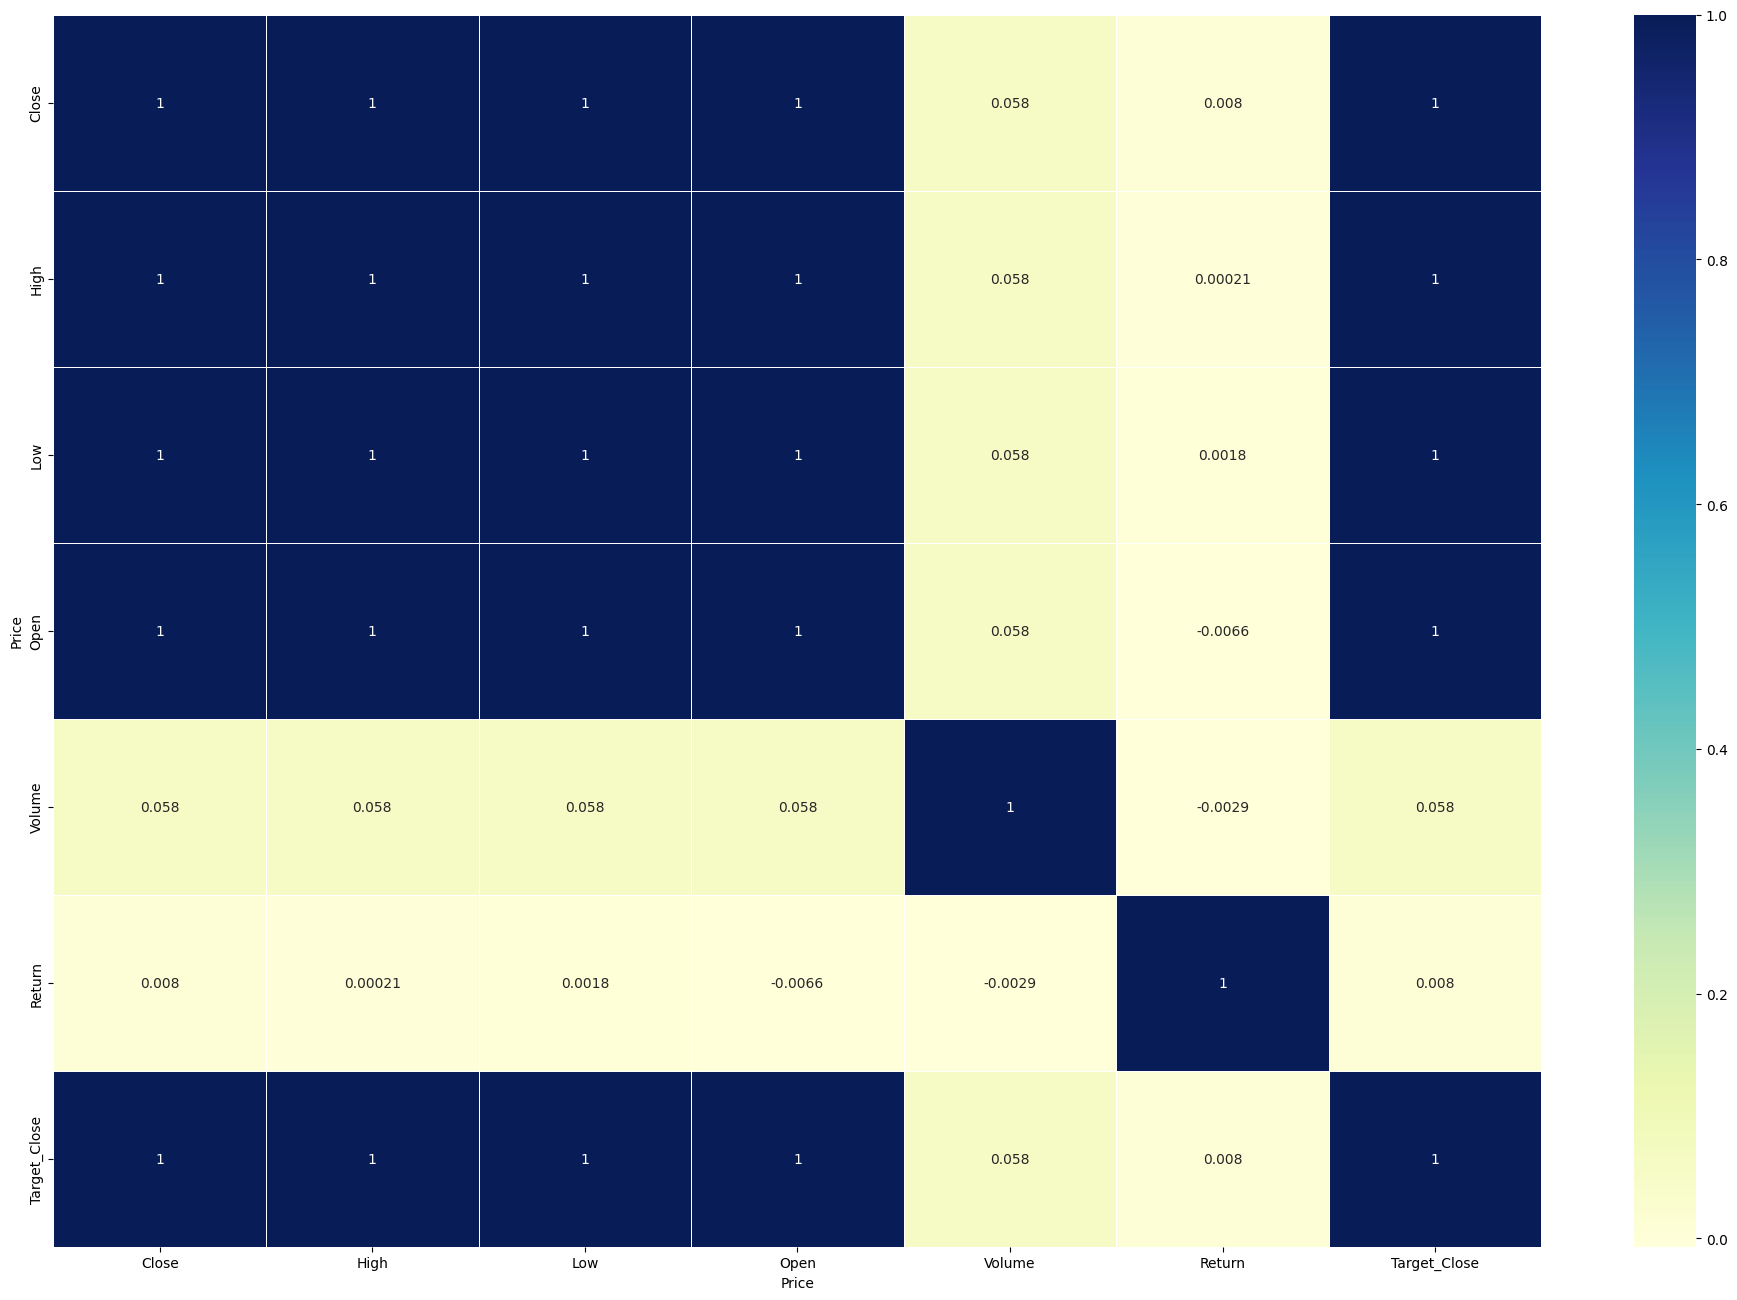

In [100]:
# Corr target
data = data.copy()

data['Target_Close'] = data['Close'].shift(-1)

data = data.dropna()

plt.figure(figsize=(24, 16))
sns.heatmap(data.corr(), annot=True, cmap='YlGnBu', cbar=True, linewidths=0.5)

In [101]:
data.head()

Price,Close,High,Low,Open,Volume,Return,Target_Close
Datetime,,,,,,,
2022-05-09 14:30:00+00:00,4010.709961,4039.280029,4009.340088,4034.209961,417559003.0,-0.005813,4041.080078
2022-05-09 15:30:00+00:00,4041.080078,4050.209961,4003.169922,4010.679932,334837856.0,0.007572,4024.959961
2022-05-09 16:30:00+00:00,4024.959961,4047.389893,4010.689941,4041.290039,258554000.0,-0.003989,4010.040039
2022-05-09 17:30:00+00:00,4010.040039,4028.159912,4004.350098,4024.979980,287488000.0,-0.003707,4005.729980
2022-05-09 18:30:00+00:00,4005.729980,4034.300049,4001.050049,4010.090088,363135000.0,-0.001075,3993.260010


In [ ]:
X = data['Close']
y = data['Target_Close']

In [ ]:
#Le MinMaxScaler est utilisé ici
#car il permet de ramener les valeurs absolues des prix dans une plage normalisée, facilitant l’apprentissage du modèle.
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(data['Close'].values.reshape(-1, 1))
y_scaled = scaler_y.fit_transform(data['Target_Close'].values.reshape(-1, 1))

In [104]:
# fonction pour créer une fênetre
def create_sequences(features, target, seq_length=45):
    X_seq, y_seq = [], []
    for i in range(len(features) - seq_length - 1):
        X_seq.append(features[i:i+seq_length])
        y_seq.append(target[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.1, shuffle=False)

In [106]:
# GRU
model = Sequential([
    GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    GRU(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mse'])


/Users/julienbellande/.pyenv/versions/3.10.6/envs/MarketSense/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=80,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/80
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.2533 - mse: 0.2533 - val_loss: 0.5441 - val_mse: 0.5441 - learning_rate: 1.0000e-04
Epoch 2/80
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0842 - mse: 0.0842 - val_loss: 0.4015 - val_mse: 0.4015 - learning_rate: 1.0000e-04
Epoch 3/80
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.0461 - mse: 0.0461 - val_loss: 0.2132 - val_mse: 0.2132 - learning_rate: 1.0000e-04
Epoch 4/80
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0241 - val_mse: 0.0241 - learning_rate: 1.0000e-04
Epoch 5/80
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0215 - mse: 0.0215 - val_loss: 0.0044 - val_mse: 0.0044 - learning_rate: 1.0000e-04
Epoch 6/80
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0076 - val_mse: 0.0076 - learning_rate: 1.0000e-04
Epoch 7/80
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0039 - val_mse: 0.0039

In [108]:
y_pred = model.predict(X_test)
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler_y.inverse_transform(y_pred)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


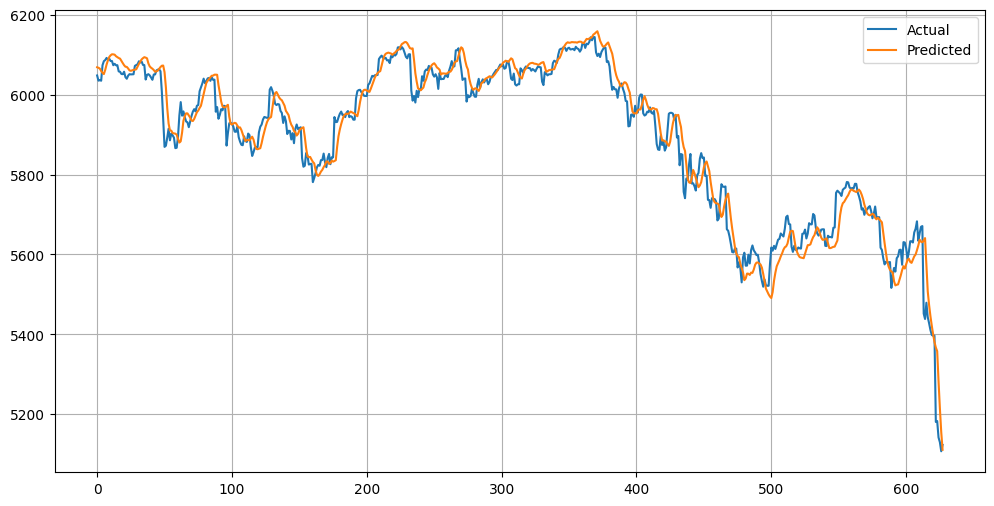

In [116]:
# Résultat graphique
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred_actual, label='Predicted')
plt.legend()
plt.grid()
plt.show()

### Les valeurs prédites suivent assez bien la direction et les valeurs réelles

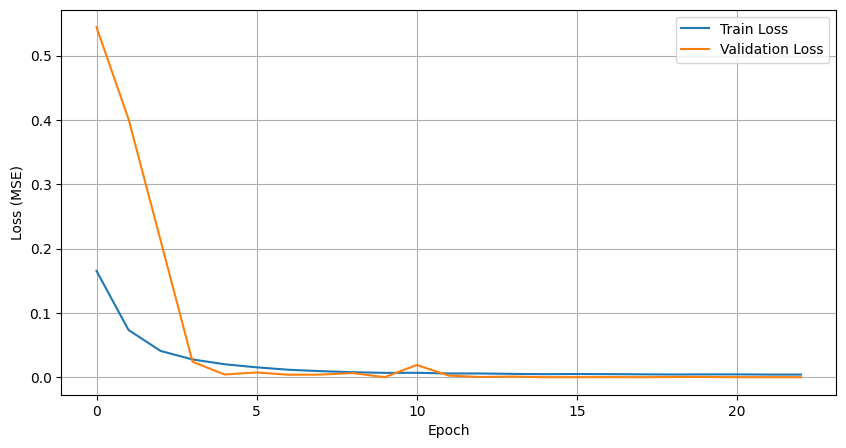

In [127]:
# Courbe d'apprentissage
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()

### Le modèle montre une bonne capacité d’apprentissage malgré le manque de données.

In [124]:
# Création d’un DataFrame pour comparer les courbes de loss
df_loss = pd.DataFrame({
    'Train Loss': history.history['loss'],
    'Validation Loss': history.history['val_loss']
})

df_loss['Absolute Difference'] = np.abs(df_loss['Train Loss'] - df_loss['Validation Loss'])

df_loss

,Train Loss,Validation Loss,Absolute Difference
0,0.165340,0.544129,0.378790
1,0.073569,0.401477,0.327908
2,0.041002,0.213162,0.172161
3,0.027751,0.024123,0.003628
4,0.020303,0.004376,0.015927
5,0.015520,0.007559,0.007961
6,0.011739,0.003947,0.007792
7,0.009573,0.004196,0.005377
8,0.007942,0.006602,0.001340
9,0.006887,0.000245,0.006642


In [125]:
#R2
from sklearn.metrics import r2_score
r2 = r2_score(y_test_actual, y_pred_actual)
print(f"R2 Score: {r2}")

R2 Score: 0.9516780846699444


### Très Bon Score

In [126]:
model.save('GRU_Agent.keras')